<a href="https://colab.research.google.com/github/agustinparada/Fisica_Computacional_I/blob/master/Actividad6/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***ACTIVIDAD 6***
José Agustín Parada Peralta. 219209388

Departamento de Física.

Universidad de Sonora.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as pdut

%matplotlib inline

In [78]:
# Definimos la URL del archivo con los datos desde una página web, al igual que le asignamos los parámetros necesarios para su correcta lectura.
# También definimos el nombre de las columnas del dataframe.
url = 'https://raw.githubusercontent.com/agustinparada/Fisica_Computacional_I/master/Actividad1/10163.txt'

cols=['fecha', 'precip (mm)', 'evap (mm)', 'Tmax (°C)', 'Tmin (°C)']
df=pd.read_csv(url,names=cols,encoding='cp1251',skiprows=19,skipfooter=1,sep='\s+',header=None, engine='python')

# Creamos una copia de nuestra estructura de datos original para que, en caso de así requerirlo, poder ser capaces de tener un respaldo de los datos originales.
# Y procedemos a trabajar con la copia de los datos.
df_copi=df.copy()

# Reemplazaremos los valores string 'Nulo' presentes en el dataframe para reemplazarlos por vacíos.
# Asignamos a una nueva copia la estructura de los datos con los valores reemplazados.
valor='Nulo'
df_copi2=df_copi.replace(to_replace=valor, value='', regex=True)

# Convertimos los datos presentes en las columnas a lo que son, datos numéricos flotantes.
cols=['precip (mm)', 'evap (mm)', 'Tmax (°C)', 'Tmin (°C)']
for c in cols:
  df_copi2[c]=pd.to_numeric(df_copi2[c],errors='coerce')

# Creamos una copia nueva, de respaldo.
df_cop=df_copi2.copy()

# Ahora hagamos que detecte que el primer dato de fecha es el día.
df_cop['fecha']=pd.to_datetime(df_cop['fecha'],dayfirst=True).copy()

# Creamos dos columnas nuevas con los años y los meses (variables enteras).
df_cop['Año']=df_cop['fecha'].dt.year
df_cop['Mes']=df_cop['fecha'].dt.month
df_meteo=df_cop.copy()

#Reemplazamos, en el caso de los meses, sus números por sus palabras.
df_meteo.drop('Mes', axis=1, inplace=True)
df_meteo['Mes']=df_meteo['fecha'].dt.strftime('%b')

ciu='Cd. Lerdo, Durango'

# Ahora reemplazaremos los índices de los renglones con las fechas correspondientes.
df_meteo_ti=df_meteo.copy()
df_meteo_ti=df_meteo_ti.set_index('fecha')
print(df_meteo_ti)

            precip (mm)  evap (mm)  Tmax (°C)  Tmin (°C)   Año  Mes
fecha                                                              
1981-09-01          0.0        5.9       31.5       15.5  1981  Sep
1981-09-02          0.0        5.9       31.5       15.5  1981  Sep
1981-09-03          0.0        5.9       31.5       15.5  1981  Sep
1981-09-04          0.0        5.9       31.5       15.5  1981  Sep
1981-09-05          0.0        5.9       31.5       15.5  1981  Sep
...                 ...        ...        ...        ...   ...  ...
2013-12-27          0.0        NaN        9.0        5.0  2013  Dec
2013-12-28          0.0        NaN       17.0        5.0  2013  Dec
2013-12-29          0.0        NaN       21.0        4.0  2013  Dec
2013-12-30          0.0        NaN       10.0        7.0  2013  Dec
2013-12-31          0.0        NaN       21.0        3.0  2013  Dec

[9935 rows x 6 columns]


In [79]:
#Definimos la fucnión de prueba de Dickey-Fuller para hacer el proceso de prueba de estacionaridad más práctico
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles anuales
    rolmean = df_ts.rolling(window=365, center=True, min_periods=1).mean()
    rolstd = df_ts.rolling(window=365, center=True, min_periods=1).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Media móvil anual')
    plt.plot(rolstd, color='black', label = 'Desviación estándar móvil')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','valor de p','#Lags Usados','Número de observaciones usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    print(dfoutput)

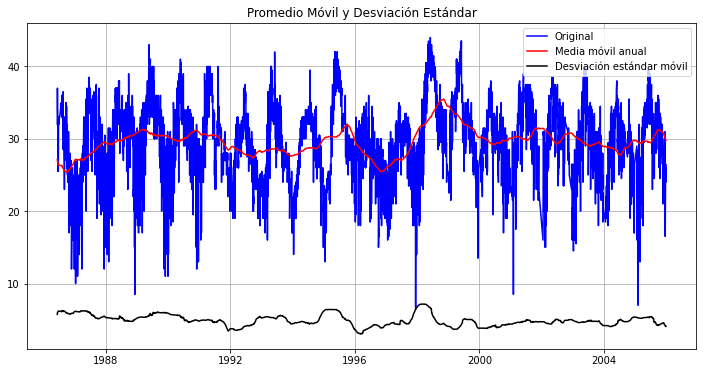

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -6.253641e+00
valor de p                        4.392317e-08
#Lags Usados                      1.700000e+01
Número de observaciones usadas    6.794000e+03
Valor Crítico (1%)               -3.431313e+00
Valor Crítico (5%)               -2.861966e+00
Valor Crítico (10%)              -2.566996e+00
dtype: float64


In [80]:
# Seleccionamos un periodo de 20 años e interpolamos los pocos valores nulos a TEMP MÁXIMAS
dft=df_meteo_ti[(df_meteo_ti['Año']>=1986)&(df_meteo_ti['Año']<2006)]
dft.columns=['Precip','Evap','Tmax','Tmin','Año','Mes']
dft_Tmax=dft['Tmax'].copy()
dft_Tmax.interpolate('linear',inplace=True)
test_stationarity(dft_Tmax)

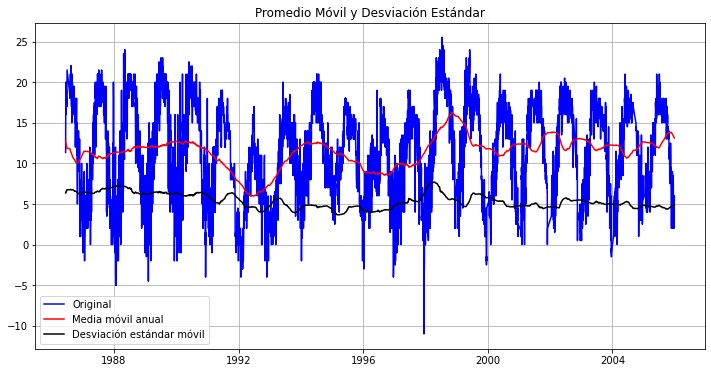

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -5.728155e+00
valor de p                        6.696090e-07
#Lags Usados                      3.500000e+01
Número de observaciones usadas    6.776000e+03
Valor Crítico (1%)               -3.431315e+00
Valor Crítico (5%)               -2.861967e+00
Valor Crítico (10%)              -2.566997e+00
dtype: float64


In [81]:
# interpolamos los pocos valores nulos y aplicamos test a TEMP MÍNIMAS
dft_Tmin=dft['Tmin'].copy()
dft_Tmin.interpolate('linear',inplace=True)
dft_Tmin.fillna(dft.Tmin.mean(), inplace=True)
test_stationarity(dft_Tmin)

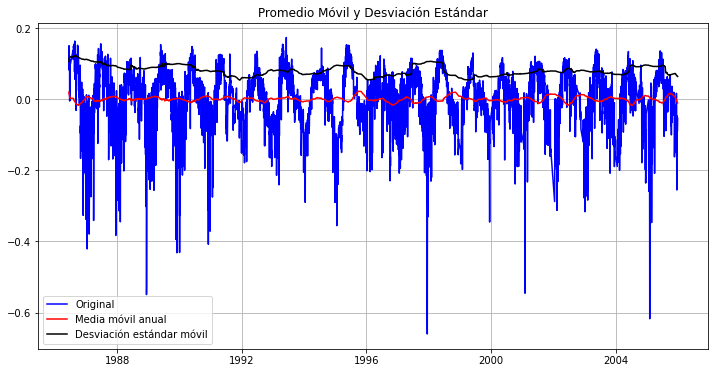

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -6.299958e+00
valor de p                        3.431467e-08
#Lags Usados                      3.500000e+01
Número de observaciones usadas    6.776000e+03
Valor Crítico (1%)               -3.431315e+00
Valor Crítico (5%)               -2.861967e+00
Valor Crítico (10%)              -2.566997e+00
dtype: float64


In [82]:
#Graficamos la escala logarítmica con diferencia de promedio móvil a TEMP. MÁXIMAS
dft_log_Tmax=np.log10(dft_Tmax)
mov_avg=dft_log_Tmax.rolling(365, center=True, min_periods=1).mean()
dft_log_Tmax_dif=dft_log_Tmax-mov_avg
test_stationarity(dft_log_Tmax_dif)

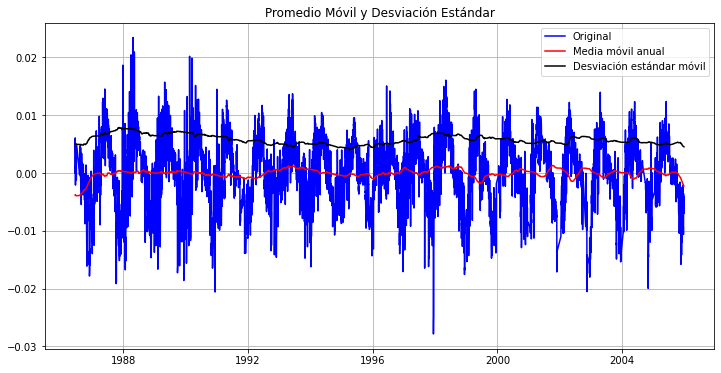

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -6.250020e+00
valor de p                        4.477718e-08
#Lags Usados                      2.800000e+01
Número de observaciones usadas    6.783000e+03
Valor Crítico (1%)               -3.431314e+00
Valor Crítico (5%)               -2.861966e+00
Valor Crítico (10%)              -2.566997e+00
dtype: float64


In [83]:
# Convertimos a grados Kelvin las TEMP. MÍNIMAS y aplicamos escala logarítmica y obtenemos la diferencia con promedio móvil exponencial.
dft_Tmin=dft_Tmin+273
dft_log_Tmin=np.log10(dft_Tmin)
ewm_avg=dft_log_Tmin.ewm(halflife=30).mean()
dft_log_Tmin_dif=dft_log_Tmin-ewm_avg
test_stationarity(dft_log_Tmin_dif)

# ***Eliminamos la estacionaridad***
Mediante la función shift()

In [84]:
# Temperaturas máximas
dft_log_Tmax_diff=dft_log_Tmax-dft_log_Tmax.shift(periods=7)
dft_log_Tmax_diff.dropna(inplace=True)

# Temperaturas mínimas
dft_log_Tmin_diff=dft_log_Tmin-dft_log_Tmin.shift(periods=7)
dft_log_Tmin_diff.dropna(inplace=True)

# ***ARIMA***

Temperaturas máximas:


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


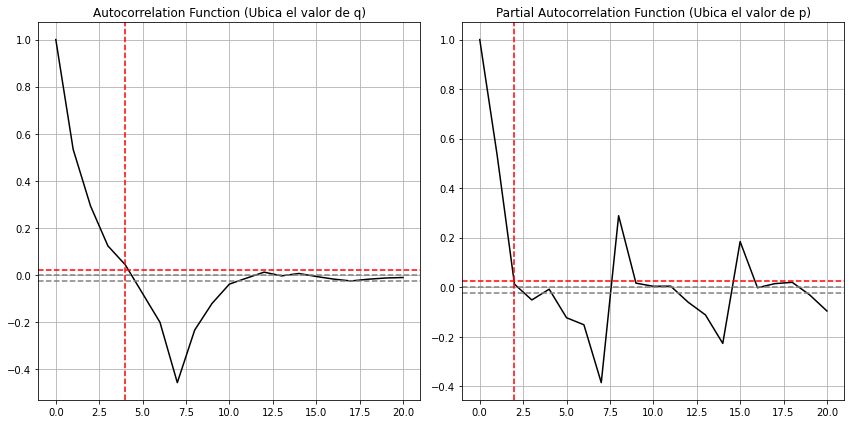

In [85]:
# TEMP. MÁXIMAS

lag_acf = acf(dft_log_Tmax_diff, nlags=20)
lag_pacf = pacf(dft_log_Tmax_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf,color='black')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dft_log_Tmax_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dft_log_Tmax_diff)), linestyle='--', color='red')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='red')
plt.axvline(x=4, linestyle='--', color='red')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf,color='black')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dft_log_Tmax_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dft_log_Tmax_diff)), linestyle='--', color='red')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='red')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Temperaturas Mínimas:

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


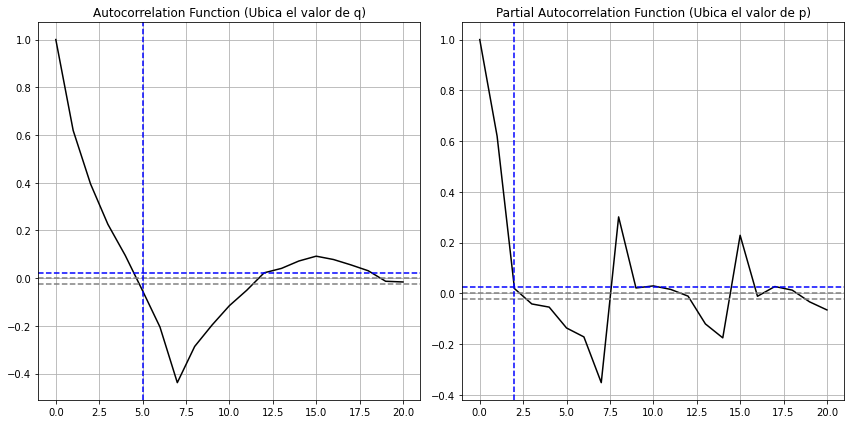

In [86]:
# TEMP. MÍNIMAS

lag_acf = acf(dft_log_Tmin_diff, nlags=20)
lag_pacf = pacf(dft_log_Tmin_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf,color='black')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dft_log_Tmin_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dft_log_Tmin_diff)), linestyle='--', color='blue')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='blue')
plt.axvline(x=5, linestyle='--', color='blue')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf,color='black')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dft_log_Tmin_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dft_log_Tmin_diff)), linestyle='--', color='blue')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='blue')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

# ***Modelo AR (Auto-Regresivo)***

Temperaturas máximas:

In [87]:
# TEMP. MÁXIMAS
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(dft_log_Tmax, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 6811
Model:                 ARIMA(2, 1, 0)   Log Likelihood               11000.248
Method:                       css-mle   S.D. of innovations              0.048
Date:                Sat, 20 Feb 2021   AIC                         -21992.496
Time:                        02:52:23   BIC                         -21965.191
Sample:                             1   HQIC                        -21983.074
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.628e-05      0.000     -0.041      0.968      -0.001       0.001
ar.L1.D.Tmax    -0.2794      0.012    -23.424      0.000      -0.303      -0.256
ar.L2.D.Tmax    -0.1762      0.012    -14.77

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Temperaturas mínimas:

In [88]:
# TEMP. MÍNIMAS
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(dft_log_Tmin, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 6811
Model:                 ARIMA(2, 1, 0)   Log Likelihood               29546.929
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -59085.858
Time:                        02:52:23   BIC                         -59058.553
Sample:                             1   HQIC                        -59076.436
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.829e-06   2.74e-05     -0.067      0.947   -5.56e-05     5.2e-05
ar.L1.D.Tmin    -0.2405      0.012    -20.068      0.000      -0.264      -0.217
ar.L2.D.Tmin    -0.1551      0.012    -12.94

# ***Modelo MA (Promedio Móvil)***

Temperaturas máximas:

In [89]:
# TEMP. MÁXIMAS
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(dft_log_Tmax, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 6811
Model:                 ARIMA(0, 1, 4)   Log Likelihood               11348.227
Method:                       css-mle   S.D. of innovations              0.046
Date:                Sat, 20 Feb 2021   AIC                         -22684.454
Time:                        02:52:25   BIC                         -22643.496
Sample:                             1   HQIC                        -22670.321
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.948e-05      0.000     -0.168      0.867      -0.000       0.000
ma.L1.D.Tmax    -0.3978      0.012    -32.976      0.000      -0.421      -0.374
ma.L2.D.Tmax    -0.2034      0.013    -15.90

Temperaturas mínimas:

In [90]:
# TEMP. MÍNIMAS
# Modelo MA(q): (p,d,q) = (0,1,5) 
model = ARIMA(dft_log_Tmin, order=(0,1,5), missing='drop')
results_MA = model.fit(displ=-1)
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 6811
Model:                 ARIMA(0, 1, 5)   Log Likelihood               29760.357
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -59506.714
Time:                        02:52:26   BIC                         -59458.930
Sample:                             1   HQIC                        -59490.226
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -2.59e-06   1.16e-05     -0.224      0.823   -2.53e-05    2.01e-05
ma.L1.D.Tmin    -0.3134      0.012    -25.837      0.000      -0.337      -0.290
ma.L2.D.Tmin    -0.1671      0.013    -13.21

# ***Modelo ARIMA (Auto-Regresión + Promedio móvil)***

Temperaturas máximas:

In [91]:
# TEMP. MÁXIMAS
model = ARIMA(dft_log_Tmax, order=(2,1,4), missing='drop')
results_ARIMA_Tmax = model.fit(displ=-1)
print(results_ARIMA_Tmax.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 6811
Model:                 ARIMA(2, 1, 4)   Log Likelihood               11360.613
Method:                       css-mle   S.D. of innovations              0.046
Date:                Sat, 20 Feb 2021   AIC                         -22705.226
Time:                        02:52:35   BIC                         -22650.616
Sample:                             1   HQIC                        -22686.383
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.92e-05      0.000     -0.176      0.860      -0.000       0.000
ar.L1.D.Tmax    -0.3641      0.099     -3.688      0.000      -0.558      -0.171
ar.L2.D.Tmax     0.4174      0.055      7.65

In [92]:
# TEMP. MÍNIMAS
model = ARIMA(dft_log_Tmin, order=(2,1,5), missing='drop')
results_ARIMA_Tmin = model.fit(displ=-1)
print(results_ARIMA_Tmin.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 6811
Model:                 ARIMA(2, 1, 5)   Log Likelihood               29762.606
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -59507.212
Time:                        02:52:41   BIC                         -59445.775
Sample:                             1   HQIC                        -59486.013
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.597e-06   1.12e-05     -0.232      0.817   -2.46e-05    1.94e-05
ar.L1.D.Tmin     0.1683        nan        nan        nan         nan         nan
ar.L2.D.Tmin     0.1449        nan        na

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


Temperaturas mínimas:

# ***Elección del modelo***
Basándonos en los valores AIC de los modelos vistos (AR, MA, ARIMA), los cuales son:

TEMP. MÁX

ARIMA(2,1,0) -> AIC=-21992

ARIMA(0,1,4)= -> AIC=-22684

ARIMA(2,1,4) -> AIC=-22705

**Entonces, el modelo ARIMA(2,1,4) es el mejor.**

TEMP. MÍN.

ARIMA(2,1,0) -> AIC=-59084

ARIMA(0,1,5)= -> AIC=-59506

ARIMA(2,1,5) -> AIC=-59507

**Entonces, el modelo ARIMA(2,1,5) es el mejor.**


In [93]:
# Creamos un dataframe para almacenar las predicciones de ARIMA(2,1,4) (el último aplicado). TEMP. MÁXIMAS
predictions_ARIMA_diff_Tmax = pd.Series(results_ARIMA_Tmax.fittedvalues, copy=True)
print(predictions_ARIMA_diff_Tmax)

fecha
1986-06-14   -0.000019
1986-06-15   -0.013590
1986-06-16   -0.011745
1986-06-17   -0.000390
1986-06-18    0.001601
                ...   
2005-12-23   -0.008929
2005-12-24   -0.029368
2005-12-25   -0.004561
2005-12-26   -0.015619
2005-12-27   -0.015634
Length: 6811, dtype: float64


In [94]:
# Creamos un dataframe para almacenar las predicciones de ARIMA(2,1,4) (el último aplicado). TEMP. MÍNIMAS
predictions_ARIMA_diff_Tmin = pd.Series(results_ARIMA_Tmin.fittedvalues, copy=True)
print(predictions_ARIMA_diff_Tmin)

fecha
1986-06-14   -0.000003
1986-06-15   -0.002548
1986-06-16   -0.002091
1986-06-17   -0.001866
1986-06-18    0.000270
                ...   
2005-12-23    0.001374
2005-12-24    0.000694
2005-12-25   -0.000852
2005-12-26    0.000231
2005-12-27   -0.000331
Length: 6811, dtype: float64


In [95]:
# Añadimos las predicciones ARIMA a la serie observada
predictions_ARIMA_log_Tmax = pd.Series(dft_log_Tmax, index = dft_log_Tmax.index)
predictions_ARIMA_log_Tmax = predictions_ARIMA_log_Tmax.add(predictions_ARIMA_diff_Tmax)
print(predictions_ARIMA_log_Tmax.head())
print(predictions_ARIMA_log_Tmax.tail())

fecha
1986-06-13         NaN
1986-06-14    1.562274
1986-06-15    1.554611
1986-06-16    1.519734
1986-06-17    1.531089
dtype: float64
fecha
2005-12-23    1.414317
2005-12-24    1.350843
2005-12-25    1.393379
2005-12-26    1.399355
2005-12-27    1.399340
dtype: float64


In [96]:
# Añadimos las predicciones ARIMA a la serie observada
predictions_ARIMA_log_Tmin = pd.Series(dft_log_Tmin, index = dft_log_Tmin.index)
predictions_ARIMA_log_Tmin = predictions_ARIMA_log_Tmin.add(predictions_ARIMA_diff_Tmin)
print(predictions_ARIMA_log_Tmin.head())
print(predictions_ARIMA_log_Tmin.tail())

fecha
1986-06-13         NaN
1986-06-14    2.466123
1986-06-15    2.464320
1986-06-16    2.464776
1986-06-17    2.459032
dtype: float64
fecha
2005-12-23    2.442283
2005-12-24    2.446298
2005-12-25    2.441628
2005-12-26    2.444275
2005-12-27    2.445273
dtype: float64


RMSE: 1.2667433151057703


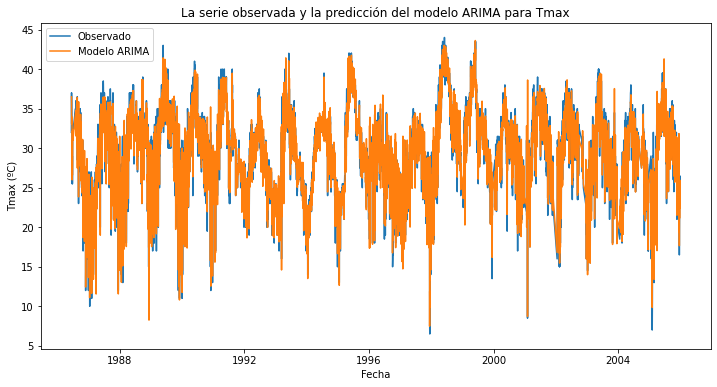

In [97]:
# Temperaturas Máximas
# Regresamos a los datos originales rivirtiendo la escala logarítmica.
predictions_ARIMA_Tmax = 10**(predictions_ARIMA_log_Tmax)

# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(dft_Tmax, label='Observado')
plt.plot(predictions_ARIMA_Tmax, label='Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best')
plt.savefig('ARIMA_Tmax.jpg')

RMSE = np.sqrt(np.mean((predictions_ARIMA_Tmax - dft_Tmax)**2))
print('RMSE:', RMSE)

RMSE: 0.7464393307614091


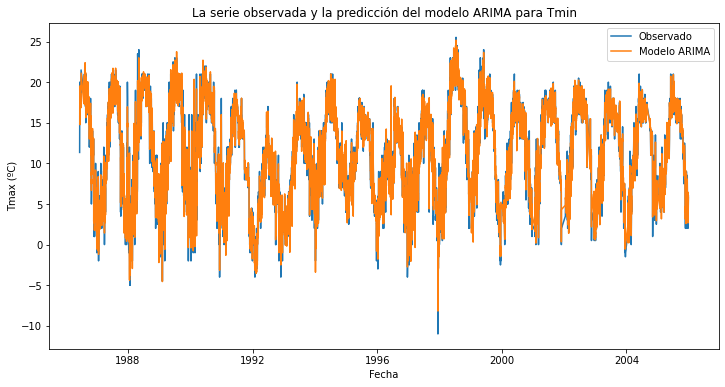

In [98]:
# Temperaturas Mínimas.
# Revertimos la escala logarítmica y la escala de temperaturas Kelvin. Convertimos a Celsius.
predictions_ARIMA_Tmin = 10**(predictions_ARIMA_log_Tmin)
predictions_ARIMA_Tmin=predictions_ARIMA_Tmin-273
dft_Tmin_c=dft_Tmin-273
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(dft_Tmin_c, label='Observado')
plt.plot(predictions_ARIMA_Tmin, label='Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best')
plt.savefig('ARIMA_Tmin.jpg')

RMSE = np.sqrt(np.mean((predictions_ARIMA_Tmin - dft_Tmin_c)**2))
print('RMSE:', RMSE)